# 🪙 El Dólar vs las Commodities

## Hipótesis del análisis

El dólar estadounidense (USD) es la moneda base con la que se cotizan la mayoría de las materias primas en el mundo. 
Por eso, existe una creencia extendida en los mercados: **cuando el dólar se fortalece, los precios de las commodities tienden a caer.**

En este análisis queremos comprobar si esa relación realmente existe y cómo ha evolucionado en el tiempo.  
Para ello:

1. Calcularemos los **rendimientos logarítmicos** del índice del dólar (DXY) y de una serie de commodities representativas 
   (oro, plata, petróleo y cobre).
2. Analizaremos la **correlación entre el dólar y cada commodity**, tanto de forma estática como con ventanas móviles.
3. Observaremos cómo cambia la relación a lo largo del tiempo, especialmente en períodos de alta inflación o crisis.
4. Probamos si el dólar puede **explicar estadísticamente los movimientos de las materias primas** mediante una regresión lineal.

Este estudio busca responder una pregunta fundamental:  
> ¿Hasta qué punto un dólar fuerte presiona los precios de las materias primas, o la relación es más compleja de lo que parece?

---


In [1]:
# ==========================================
# BLOQUE 1: IMPORTACIÓN DE LIBRERÍAS
# ==========================================
# Importamos las principales librerías de análisis y visualización de datos.

import yfinance as yf              # Para descargar precios de Yahoo Finance
import pandas as pd                # Manipulación de datos (estructuras tipo DataFrame)
import numpy as np                 # Cálculos numéricos y logaritmos
import matplotlib.pyplot as plt    # Visualización base
import seaborn as sns              # Visualización avanzada (mapas de calor, estilos)
import statsmodels.api as sm       # Para regresiones estadísticas
from statsmodels.tsa.stattools import grangercausalitytests  # Pruebas de causalidad de Granger
from statsmodels.tsa.stattools import coint # Prueba de cointegración de Engle-Granger
from sklearn.decomposition import PCA # Análisis de componentes principales 
from sklearn.preprocessing import StandardScaler # Estandarización de datos

In [2]:
# ==========================================
# BLOQUE 2: DESCARGA DE DATOS
# ==========================================
# Definimos un diccionario con los tickers de cada activo.
# Cada clave (ej: "Gold") es el nombre que aparecerá en las columnas.
# Los valores son los códigos de Yahoo Finance.

tickers = {
    "DXY": "DX-Y.NYB",      # Índice del dólar (DXY)
    "Gold": "GC=F",         # Oro
    "Silver": "SI=F",       # Plata
    "Copper": "HG=F",       # Cobre
    "Oil": "CL=F",          # Petróleo WTI
    "NatGas": "NG=F",       # Gas natural
    "Corn": "ZC=F",         # Maíz
    "Wheat": "ZW=F"         # Trigo
}

# Descargamos precios ajustados de cierre (últimos 10 años)
data = yf.download(list(tickers.values()), start="2015-01-01", end="2025-01-01",multi_level_index=False,auto_adjust=False,progress=False)["Adj Close"]

# Renombramos las columnas con los nombres legibles definidos arriba
data.columns = tickers.keys()

# Mostramos las primeras filas
data.head()


,DXY,Gold,Silver,Copper,Oil,NatGas,Corn,Wheat
Date,,,,,,,,
2015-01-02,52.689999,91.080002,1186.000000,2.8385,3.003,15.734000,395.75,581.25
2015-01-05,50.040001,91.379997,1203.900024,2.7930,2.882,16.179001,406.00,589.00
2015-01-06,47.930000,91.500000,1219.300049,2.8040,2.938,16.603001,405.00,591.75
2015-01-07,48.650002,91.889999,1210.599976,2.7960,2.871,16.510000,396.25,579.50
2015-01-08,48.790001,92.370003,1208.400024,2.8070,2.927,16.351000,394.25,567.00


Guardar en base de datos evita re-descargar datos cada vez. SQLite es ideal para proyectos pequeños. La consulta SQL filtra fechas y ordena cronológicamente.

In [3]:
# ==========================================
# BLOQUE 2.1: PERSISTENCIA EN BASE DE DATOS
# ==========================================
# Guardamos los datos históricos en una base relacional (SQLite).
# Esto permite consultas rápidas y evita volver a descargar desde Yahoo Finance.

import sqlite3
from datetime import datetime

# Creamos la conexión (se crea el archivo si no existe)
conn = sqlite3.connect("data/commodities_data.db")

# Agregamos columna de fecha como índice
data_to_save = data.copy()
data_to_save.index.name = "Date"

# Guardamos en una tabla llamada "prices"
data_to_save.to_sql("prices", conn, if_exists="replace", index=True)

print(f"✅ Datos guardados en base de datos. Registros totales: {len(data_to_save)}")
conn.close()


✅ Datos guardados en base de datos. Registros totales: 2516


In [4]:
# ==========================================
# CONSULTA LOCAL (Extract transformado)
# ==========================================

conn = sqlite3.connect("data/commodities_data.db")

query = """
SELECT Date, DXY, Gold, Silver, Oil, NatGas, Wheat, Copper, Corn
FROM prices
WHERE Date BETWEEN '2015-01-01' AND '2025-01-01'
ORDER BY Date
"""

data_db = pd.read_sql(query, conn, parse_dates=["Date"], index_col="Date")
conn.close()

print("✅ Datos cargados desde la base:")
print(data_db.head())

✅ Datos cargados desde la base:
                  DXY       Gold       Silver    Oil     NatGas   Wheat  \
Date                                                                      
2015-01-02  52.689999  91.080002  1186.000000  3.003  15.734000  581.25   
2015-01-05  50.040001  91.379997  1203.900024  2.882  16.179001  589.00   
2015-01-06  47.930000  91.500000  1219.300049  2.938  16.603001  591.75   
2015-01-07  48.650002  91.889999  1210.599976  2.871  16.510000  579.50   
2015-01-08  48.790001  92.370003  1208.400024  2.927  16.351000  567.00   

            Copper    Corn  
Date                        
2015-01-02  2.8385  395.75  
2015-01-05  2.7930  406.00  
2015-01-06  2.8040  405.00  
2015-01-07  2.7960  396.25  
2015-01-08  2.8070  394.25  


In [5]:
# ==========================================
# BLOQUE 3: RENDIMIENTOS LOGARÍTMICOS
# ==========================================
# Los rendimientos logarítmicos (log returns) se usan para estabilizar la varianza
# y facilitar comparaciones entre activos de diferentes precios.

""" Los rendimientos logarítmicos tienen ventajas matemáticas:

1. Son aditivos en el tiempo: log(P₃/P₁) = log(P₂/P₁) + log(P₃/P₂)
2. Estabilizan varianza (importante para comparar activos de diferentes precios)
3. Aproximan rendimientos simples cuando son pequeños"""

returns = np.log(data_db / data_db.shift(1)).dropna()

returns.head()

returns.to_csv("data/1-commodity_log_returns.csv")


c:\Users\User\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


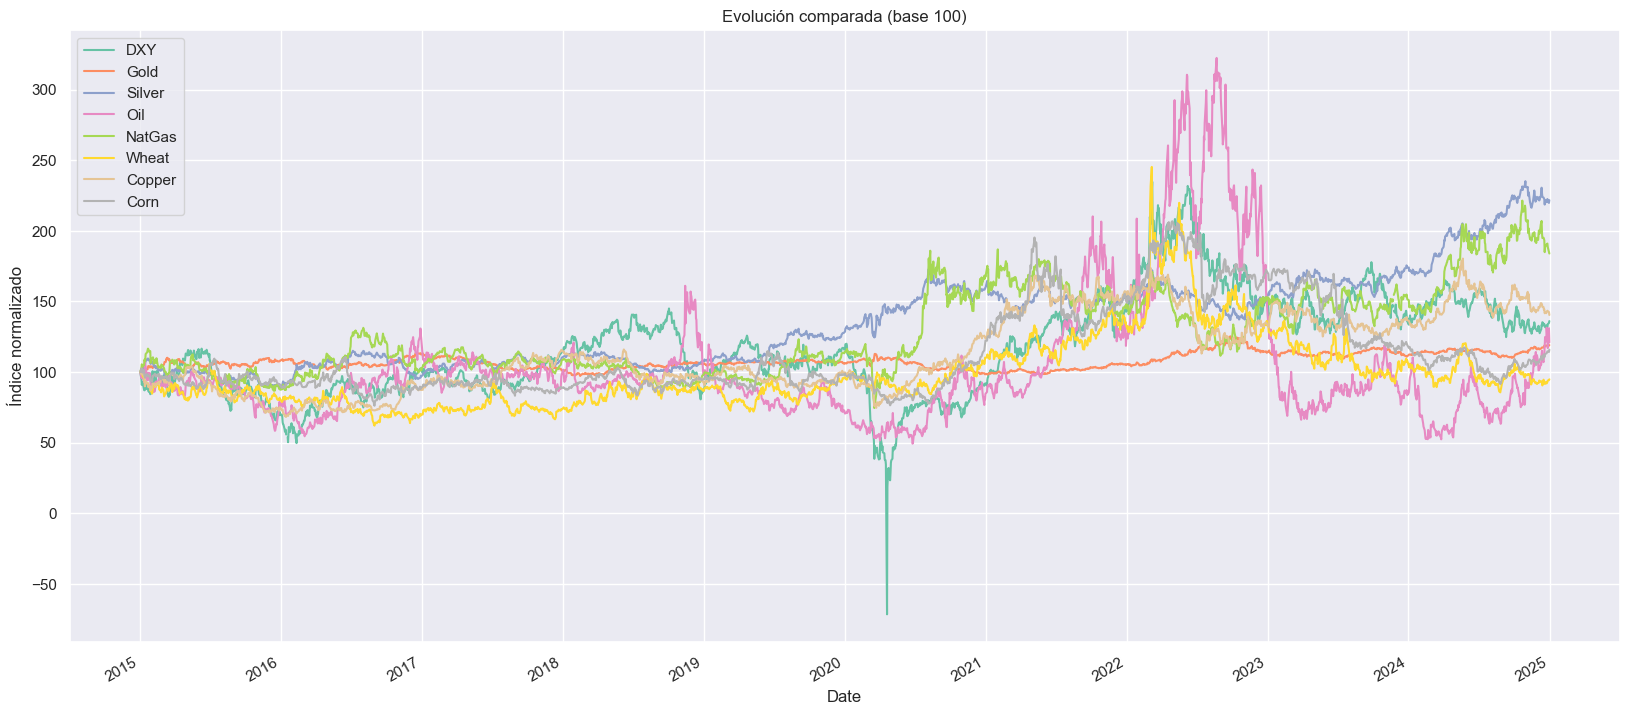

In [21]:
# ==========================================
# BLOQUE 4: EVOLUCIÓN NORMALIZADA
# ==========================================
# Normalizamos todos los activos a una base común (100 al inicio).
# Normalizar a base 100 permite comparar activos con diferentes escalas
sns.set_theme(style="darkgrid", palette="Set2")

(data_db / data_db.iloc[0] * 100).plot(figsize=(20, 9))
plt.title("Evolución comparada (base 100)")
plt.ylabel("Índice normalizado")
plt.show()



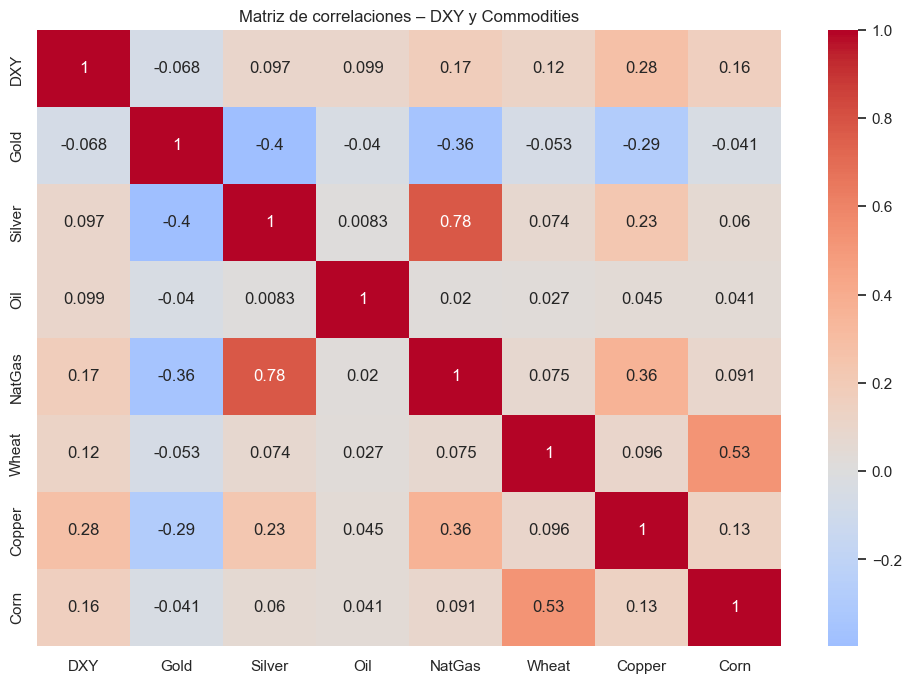

             DXY      Gold    Silver       Oil    NatGas     Wheat    Copper  \
DXY     1.000000 -0.068186  0.096510  0.099214  0.173370  0.122026  0.275223   
Gold   -0.068186  1.000000 -0.395727 -0.040045 -0.357018 -0.052842 -0.286325   
Silver  0.096510 -0.395727  1.000000  0.008265  0.780129  0.074206  0.226147   
Oil     0.099214 -0.040045  0.008265  1.000000  0.019736  0.026607  0.045113   
NatGas  0.173370 -0.357018  0.780129  0.019736  1.000000  0.075431  0.362850   
Wheat   0.122026 -0.052842  0.074206  0.026607  0.075431  1.000000  0.096311   
Copper  0.275223 -0.286325  0.226147  0.045113  0.362850  0.096311  1.000000   
Corn    0.162963 -0.040901  0.060247  0.040989  0.090522  0.531118  0.133933   

            Corn  
DXY     0.162963  
Gold   -0.040901  
Silver  0.060247  
Oil     0.040989  
NatGas  0.090522  
Wheat   0.531118  
Copper  0.133933  
Corn    1.000000  


In [ ]:
# ==========================================
# BLOQUE 5: CORRELACIÓN ESTÁTICA
# ==========================================
# Sirve para observar qué activos se mueven juntos o en sentido opuesto.
# Es "estática" porque usa todo el período sin considerar cambios temporales.

corr_matrix = returns.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlaciones – DXY y Commodities")
plt.show()

corr_matrix.to_csv("data/1-commodity_correlation_matrix.csv")
print(corr_matrix)


<Figure size 1400x900 with 0 Axes>

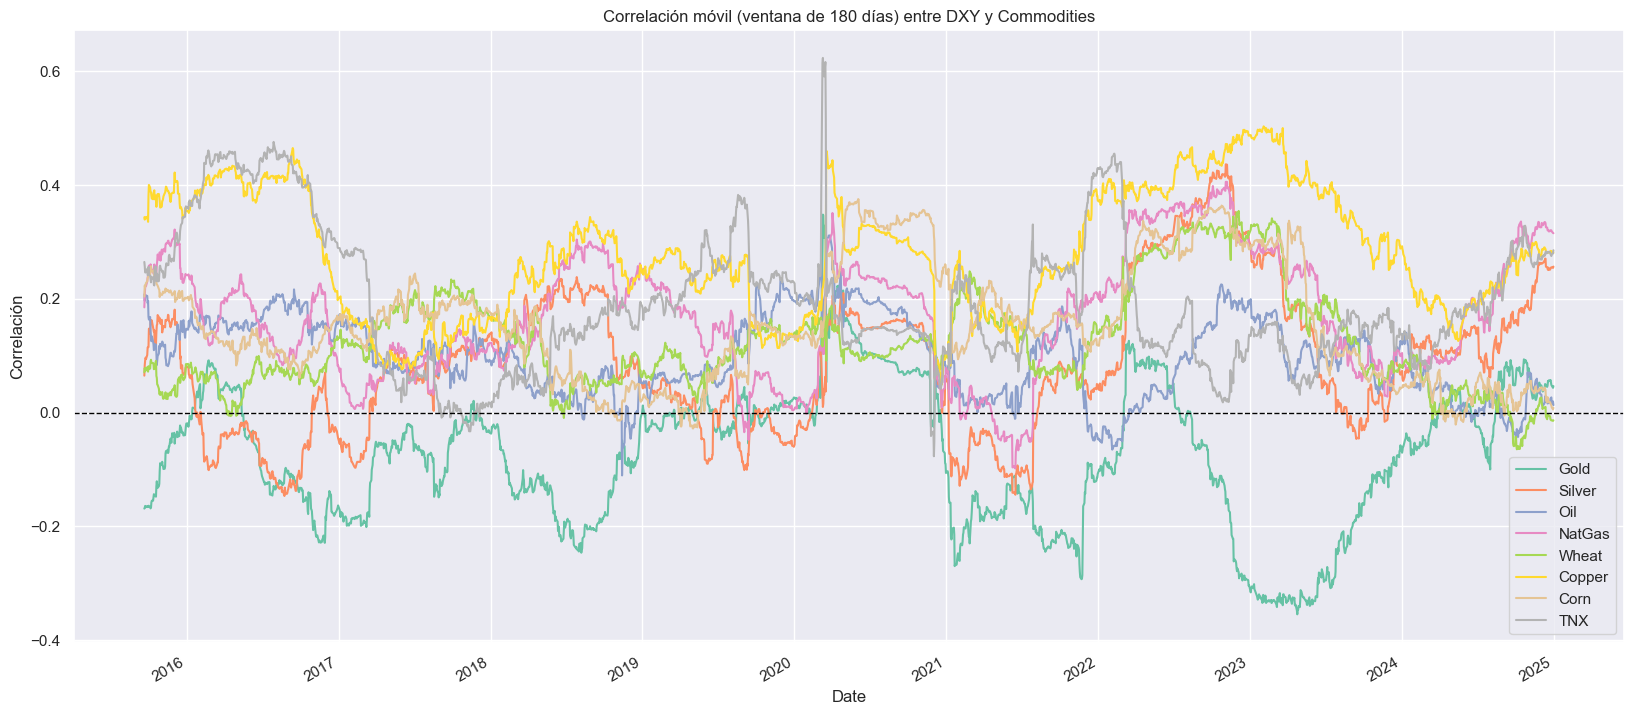

In [22]:
# ==========================================
# BLOQUE 6: CORRELACIÓN MÓVIL (ROLLING)
# ==========================================
# Calculamos la correlación de cada commodity con el DXY en una ventana móvil de 180 días.
"""Las correlaciones cambian en el tiempo (crisis, políticas monetarias, etc.). La ventana móvil de 180 días (~6 meses) capta estos cambios dinámicos, revelando períodos de mayor/menor relación inversa."""

window = 180
rolling_corr = returns.rolling(window).corr(returns["DXY"]).dropna()

plt.figure(figsize=(14,9))
rolling_corr.drop(columns=["DXY"]).plot(figsize=(20,9))
plt.title(f"Correlación móvil (ventana de {window} días) entre DXY y Commodities")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.ylabel("Correlación")
plt.legend(loc="lower right")
plt.show()


rolling_corr.to_csv("data/1-commodity_rolling_correlation.csv")


In [9]:
# ==========================================
# BLOQUE 7: CORRELACIÓN POR PERÍODOS
# ==========================================
# Analizamos tres períodos distintos para detectar cambios estructurales:
# - 2015–2019: pre-pandemia
# - 2020–2022: pandemia e inflación
# - 2023–2025: normalización monetaria

corr_periodos = {} #Dict para almacenar resultados
periodos = [("2015-01-01","2019-12-31"), ("2020-01-01","2022-12-31"), ("2023-01-01","2025-01-01")] # Definimos rango de fechas

for inicio, fin in periodos:
    #Filtra los retornos por cada período, calcula todas las correlaciones entre activos, y guarda solo las correlaciones con el dólar (DXY) usando el rango de años como etiqueta.
    corr_periodos[f"{inicio[:4]}-{fin[:4]}"] = returns.loc[inicio:fin].corr()["DXY"]

pd.DataFrame(corr_periodos) # Conevrtimos el dict a pandas dataframe


,2015-2019,2020-2022,2023-2025
DXY,1.000000,1.000000,1.000000
Gold,-0.101500,-0.044044,-0.062384
Silver,0.012805,0.154283,0.117825
Oil,0.137059,0.097566,0.053474
NatGas,0.134328,0.197351,0.183787
Wheat,0.093122,0.167130,0.049678
Copper,0.265313,0.292966,0.272327
Corn,0.130322,0.225257,0.050917


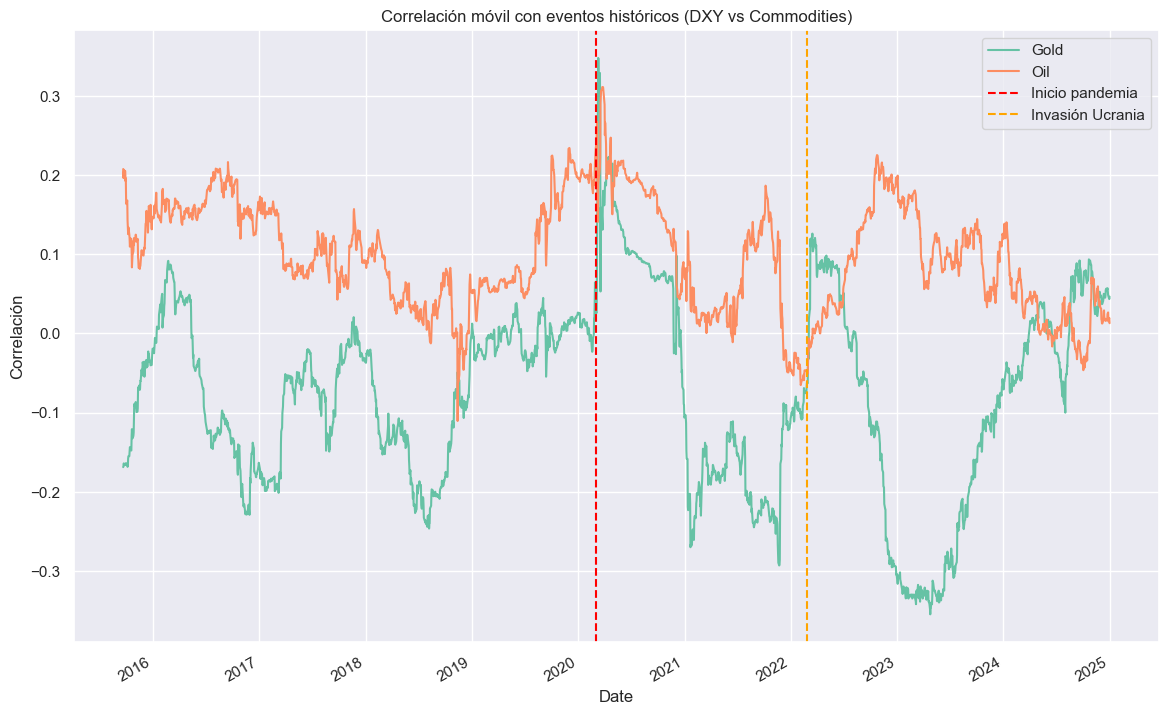

In [10]:
# Añadimos eventos históricos clave al gráfico de correlación móvil
plt.figure(figsize=(14,9))
rolling_corr["Gold"].plot(label="Gold")
rolling_corr["Oil"].plot(label="Oil")
plt.axvline("2020-03-01", color="red", linestyle="--", label="Inicio pandemia")
plt.axvline("2022-02-24", color="orange", linestyle="--", label="Invasión Ucrania")
plt.legend()
plt.title("Correlación móvil con eventos históricos (DXY vs Commodities)")
plt.ylabel("Correlación")
plt.show()


In [11]:
# ==========================================
# BLOQUE 8: REGRESIÓN LINEAL (SENSIBILIDAD)
# ==========================================
# Estimamos una regresión lineal simple para medir cuánto cambia el Oro (Gold)
# ante variaciones del dólar (DXY).
# Esto nos da el "beta" o sensibilidad del oro frente al dólar.

X = sm.add_constant(returns["DXY"]) #Añade el intercepto al modelo
y = returns["Gold"]
model = sm.OLS(y, X).fit() #Ajusta la regresión por OLS

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   Gold   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     11.69
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           0.000639
Time:                        11:02:18   Log-Likelihood:                 10056.
No. Observations:                2504   AIC:                        -2.011e+04
Df Residuals:                    2502   BIC:                        -2.010e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.529e-05   8.72e-05      0.863      0.3

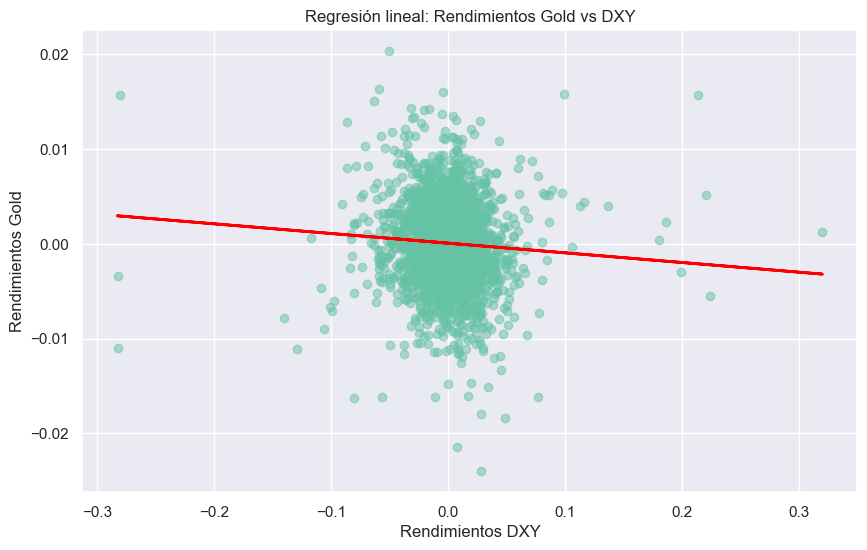

In [12]:
#Graficamos la regresión:

plt.figure(figsize=(10,6))
plt.scatter(returns["DXY"], returns["Gold"], alpha=0.5)
plt.plot(returns["DXY"], model.predict(X), color="red", linewidth=2)
plt.title("Regresión lineal: Rendimientos Gold vs DXY")
plt.xlabel("Rendimientos DXY")
plt.ylabel("Rendimientos Gold")
plt.show()


In [13]:
# ==========================================
# BLOQUE 8.1: PRUEBA DE CAUSALIDAD DE GRANGER
# ==========================================
# Verificamos si los movimientos del DXY "causan" los del Oro (predictivamente).
"""Causalidad de Granger no es causalidad real, sino predictibilidad temporal. Si valores pasados del dólar ayudan a predecir oro (p-valor < 0.05), hay "causalidad" en sentido estadístico."""


print("\n=== Prueba de Causalidad de Granger (DXY → Gold) ===\n")
granger_result = grangercausalitytests(returns[["Gold", "DXY"]].dropna(), maxlag=5, verbose=True)



=== Prueba de Causalidad de Granger (DXY → Gold) ===


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8511  , p=0.0089  , df_denom=2500, df_num=1
ssr based chi2 test:   chi2=6.8593  , p=0.0088  , df=1
likelihood ratio test: chi2=6.8500  , p=0.0089  , df=1
parameter F test:         F=6.8511  , p=0.0089  , df_denom=2500, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5795  , p=0.0280  , df_denom=2497, df_num=2
ssr based chi2 test:   chi2=7.1733  , p=0.0277  , df=2
likelihood ratio test: chi2=7.1630  , p=0.0278  , df=2
parameter F test:         F=3.5795  , p=0.0280  , df_denom=2497, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4357  , p=0.0630  , df_denom=2494, df_num=3
ssr based chi2 test:   chi2=7.3277  , p=0.0622  , df=3
likelihood ratio test: chi2=7.3170  , p=0.0625  , df=3
parameter F test:         F=2.4357  , p=0.0630  , df_denom=2494, df_num=3

Granger Causality
number of lags

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [14]:
# ==========================================
# BLOQUE 8.2: PRUEBA DE COINTEGRACIÓN (CORREGIDO)
# ==========================================

"""Cointegración detecta si dos series mantienen una relación de largo plazo (equilibrio), aunque se desvíen temporalmente. Si están cointegradas, existe un vínculo estructural más allá de correlaciones temporales."""
# Alinear las series temporalmente
aligned = pd.concat([data_db["DXY"], data_db["Gold"]], axis=1).dropna()

score, pvalue, _ = coint(aligned["DXY"], aligned["Gold"])
print(f"\nP-valor de cointegración DXY–Gold: {pvalue:.4f}")

if pvalue < 0.05:
    print("✅ Existe cointegración: relación de largo plazo entre DXY y oro.")
else:
    print("❌ No hay cointegración: la relación es sólo de corto plazo.")




P-valor de cointegración DXY–Gold: 0.2051
❌ No hay cointegración: la relación es sólo de corto plazo.


In [15]:
# ==========================================
# BLOQUE 8.3: ANÁLISIS PCA - FACTORES COMUNES
# ==========================================
"""¿Los commodities se mueven por factores comunes o independientes?"""

# Preparación de datos
X_scaled = StandardScaler().fit_transform(returns.dropna())
pca = PCA(n_components=3)  # Solo 3 componentes principales
pca.fit(X_scaled)

# Varianza explicada por cada factor
var_explicada = pd.DataFrame({
    'Componente': ['Factor 1', 'Factor 2', 'Factor 3'],
    'Varianza (%)': pca.explained_variance_ratio_ * 100
})

print("📊 Varianza explicada por factores principales:\n")
print(var_explicada.round(1))
print(f"\n✅ Total explicado con 3 factores: {var_explicada['Varianza (%)'].sum():.1f}%")

# Interpretación simple
print("\n💡 Conclusión: Se necesitan al menos 3 factores independientes")
print("   → Los commodities NO se mueven como bloque único frente al DXY")



📊 Varianza explicada por factores principales:

  Componente  Varianza (%)
0   Factor 1          30.0
1   Factor 2          19.0
2   Factor 3          13.4

✅ Total explicado con 3 factores: 62.4%

💡 Conclusión: Se necesitan al menos 3 factores independientes
   → Los commodities NO se mueven como bloque único frente al DXY


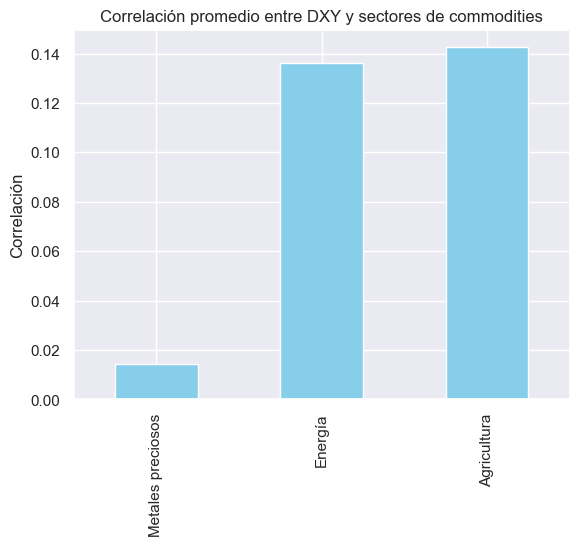

Metales preciosos    0.014162
Energía              0.136292
Agricultura          0.142494
dtype: float64


In [16]:
# ==========================================
# BLOQUE 9: CESTAS SECTORIALES
# ==========================================
# Agrupamos commodities por sector para comparar su relación promedio con el dólar.

sector_corr = {
    "Metales preciosos": corr_matrix.loc["DXY", ["Gold", "Silver"]].mean(),
    "Energía": corr_matrix.loc["DXY", ["Oil", "NatGas"]].mean(),
    "Agricultura": corr_matrix.loc["DXY", ["Corn", "Wheat"]].mean()
} #Diccionario agrupa activos por sector. mean promedia correlaciones de cada grupo.

pd.Series(sector_corr).plot(kind="bar", color="skyblue")
plt.title("Correlación promedio entre DXY y sectores de commodities")
plt.ylabel("Correlación")
plt.show()

print(pd.Series(sector_corr))


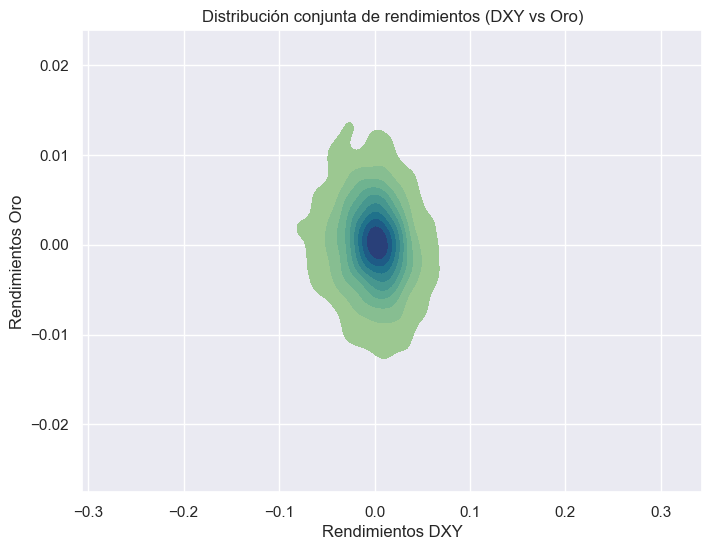

In [17]:
# ==========================================
# BLOQUE 9.1: DISTRIBUCIÓN CONJUNTA (NO LINEALIDAD)
# ==========================================
# Analizamos si la relación entre DXY y Oro es lineal o asimétrica.

"""kde plot crea mapa 2D de densidad, el famoso kernel density estimation
Verifica linealidad de la relación. Si la densidad no es elíptica, la relación puede ser asimétrica (ej: oro reacciona más a subidas que a bajadas del dólar)."""


plt.figure(figsize=(8,6))
sns.kdeplot(x=returns["DXY"], y=returns["Gold"], fill=True, cmap="crest", thresh=0.05)
plt.title("Distribución conjunta de rendimientos (DXY vs Oro)")
plt.xlabel("Rendimientos DXY")
plt.ylabel("Rendimientos Oro")
plt.show()


Es una estimación suave de la distribución conjunta que muestra qué combinaciones de rendimientos de DXY y Oro ocurren con mayor frecuencia (los colores más oscuros indican más densidad). La nube está centrada cerca de (DXY ≈ 0, Oro ≈ 0), lo que significa que la mayoría de los días ambos activos tienen rendimientos muy cercanos a cero —algo habitual en activos macro en frecuencia diaria.

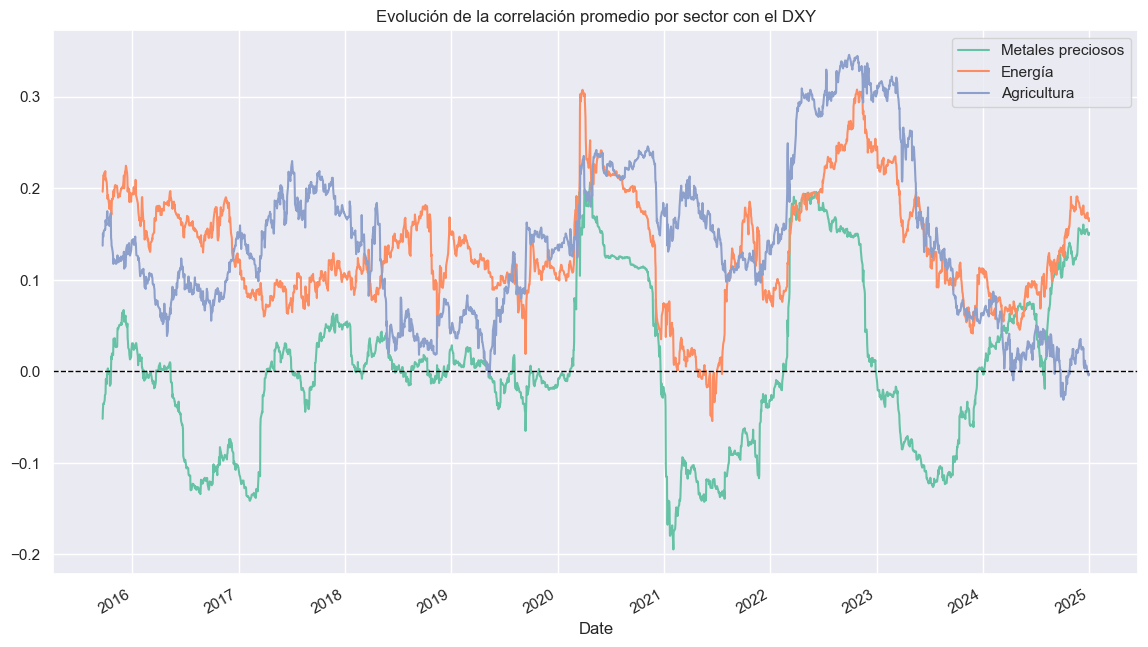

In [18]:
# ==========================================
# BLOQUE 10: CORRELACIÓN MÓVIL PROMEDIO POR SECTOR (ROLLING)
# ==========================================

#Rolling sector será un dataframe con series temporales de promedios:
"""Combina correlación móvil + cestas sectoriales. Muestra cómo evoluciona la relación promedio de cada sector con el dólar, suavizando volatilidad de activos individuales."""
rolling_sector = pd.DataFrame({
    "Metales preciosos": rolling_corr[["Gold", "Silver"]].mean(axis=1),
    "Energía": rolling_corr[["Oil", "NatGas"]].mean(axis=1),
    "Agricultura": rolling_corr[["Corn", "Wheat"]].mean(axis=1),
}) # Promediamos horizontalmente.
rolling_sector.plot(figsize=(14,8))
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Evolución de la correlación promedio por sector con el DXY")
plt.show()

In [19]:
# ==========================================
# BLOQUE 11: REGRESIÓN MÚLTIPLE CONTROLANDO POR TASAS
# ==========================================
# Sumamos al modelo la tasa de los bonos a 10 años de EE.UU. (proxy de tasas reales).

"""Las tasas de interés afectan tanto al dólar como al oro. Al incluir TNX, aislamos el efecto "puro" del DXY sobre el oro, eliminando el ruido de las tasas."""

tnx = yf.download("^TNX", start="2015-01-01", end="2025-01-01", progress=False, multi_level_index=False,auto_adjust=False)["Adj Close"]
returns["TNX"] = np.log(tnx / tnx.shift(1))

X_multi = sm.add_constant(returns[["DXY", "TNX"]].dropna())
y_multi = returns["Gold"].loc[X_multi.index]

model_multi = sm.OLS(y_multi, X_multi).fit()
print(model_multi.summary())


                            OLS Regression Results                            
Dep. Variable:                   Gold   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     68.58
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           1.01e-29
Time:                        11:02:22   Log-Likelihood:                 10117.
No. Observations:                2504   AIC:                        -2.023e+04
Df Residuals:                    2501   BIC:                        -2.021e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.638e-05   8.51e-05      0.780      0.4

El coeficiente negativo de DXY indica que, incluso controlando por las tasas, un aumento del dólar tiende a reducir el rendimiento del oro.
El coeficiente positivo de TNX muestra que las tasas explican parte del movimiento del oro, y al incluirlas, aislamos mejor el efecto real del dólar sobre el metal.